In [1]:
import pandas as pd
import numpy as np
from itertools import combinations
from scipy.stats import ttest_ind
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from scipy.stats import normaltest
from scipy import stats
from scipy.stats import shapiro

# Начальная подготовка данных и начальные проверки

In [2]:
pd.set_option('display.max_columns', 50)

In [14]:
# Список столбцов для удаления
drop_list = []

# Процедура добавления столбца в список для удаления
def drop(col):
    if col not in drop_list:
        drop_list.append(col)
        

# Функция преобразования пустых или пробельных или NaN данных строкового типа в значение None
# для числовых столбцов это не годится, так как их отсутствующие данные заполняются только NaN
def set_None(value):
    if value is None:
        return value
    else:
        str_value = str(value).strip()
        if str_value == '' or str_value.lower() == 'nan':
            return None
        else:
            return str_value
        

# Функция получения выбросов по столбцу
def get_outlier(df, col):
    Q3 = pd.DataFrame.quantile(df, q=0.75, axis=0, numeric_only=True, interpolation='midpoint')[col]
    Q1 = pd.DataFrame.quantile(df, q=0.25, axis=0, numeric_only=True, interpolation='midpoint')[col]
    IQR = round(Q3-Q1,1)
    return df[~df[col].between(Q1 - 1.5*IQR, Q3 + 1.5*IQR)][col]


# Функция вычисления попарного p_value при множественном значении столбца
def get_stat_dif(df, col, col_num, gauss):
    
    p_list =[]
    res = '' 
    
    cols = df.loc[:, col].value_counts().index
    combinations_all = list(combinations(cols, 2))
    conv = 0.05 / len(combinations_all) # пороговый уровень значимости с поправкой Бонферрони
    
    for comb in combinations_all:
        if gauss:
            p_value = ttest_ind(df.loc[df.loc[:, col] == comb[0], col_num], 
                     df.loc[df.loc[:, col] == comb[1], col_num]).pvalue
        else:
            p_value = stats.mannwhitneyu(df.loc[df.loc[:, col] == comb[0], col_num],
                     df.loc[df.loc[:, col] == comb[1], col_num]).pvalue
        
        p_list.append(p_value)
        
        if p_value < conv:
            res = ' значимость есть: для ' + str(comb) + ' p_value = ' + str(p_value)
            break
            
    if res == '':
        res = ' значимости нет: min(p_value) = ' + str(min(p_list))
    
    if gauss:
        res = 'Для порога ' + str(conv) + ' по критерию Стьюдента' + res
    else:
        res = 'Для порога ' + str(conv) + ' по критерию Манна-Уитни' + res
    
    return res

In [3]:
stud = pd.read_csv('stud_math.csv')

In [4]:
# В наборе еще присутствует столбец "studytime, granular". Переименуем его.

stud.rename(columns={'studytime, granular': 'studytime_granular',}, inplace=True)

In [5]:
stud.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_granular,higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


In [6]:
stud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   school              395 non-null    object 
 1   sex                 395 non-null    object 
 2   age                 395 non-null    int64  
 3   address             378 non-null    object 
 4   famsize             368 non-null    object 
 5   Pstatus             350 non-null    object 
 6   Medu                392 non-null    float64
 7   Fedu                371 non-null    float64
 8   Mjob                376 non-null    object 
 9   Fjob                359 non-null    object 
 10  reason              378 non-null    object 
 11  guardian            364 non-null    object 
 12  traveltime          367 non-null    float64
 13  studytime           388 non-null    float64
 14  failures            373 non-null    float64
 15  schoolsup           386 non-null    object 
 16  famsup  

In [7]:
# Так как оценка - главный объект исследования, удалим строки с отсутствующими оценками.

stud = stud[~stud.score.isnull()]

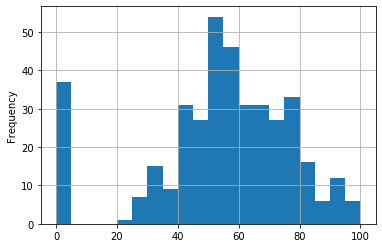

In [8]:
# Проверим вид распределения оценок

stud['score'].plot(kind = 'hist', grid = True, bins=20)

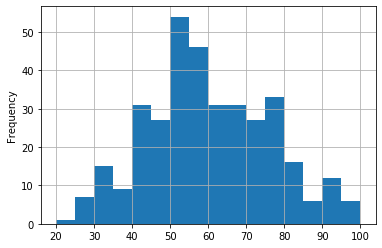

In [10]:
# На гистограмме видно, что ненулевые оценки близки к нормальному распределению,
# но нулевые оценки выбиваются из этой картины.
# Исключим их из рассмотрения, поскольку они не укладываются в нормальное распределение,
# и по причине того, что нулевые оценки обычно не ставят. Скорее всего, это ошибочные данные.

stud = stud[stud.score > 0]
stud['score'].plot(kind = 'hist', grid = True, bins=16)

In [15]:
print('Количество выбросов:', get_outlier(stud,'score').count())

Количество выбросов: 0


In [16]:
# Выбросов нет. 
# Проверим на нормальность распределения по двум критериям с допущением 0.05.

alpha = 0.05

u, p_value = shapiro(stud.score)
print('shapiro p_value=', p_value)
if p_value > alpha:
    print('По shapiro распределение подобно нормальному')
else:
    print('По shapiro распределение не похоже на нормальное')
    
u, p_value = normaltest(stud.score)
print('normaltest p_value=', p_value)
if p_value > alpha:
    print('По normaltest распределение подобно нормальному')
else:
    print('По normaltest распределение не похоже на нормальное')

shapiro p_value= 0.0001710323995212093
По shapiro распределение не похоже на нормальное
normaltest p_value= 0.051812401238085656
По normaltest распределение подобно нормальному


In [17]:
# Вывод: распределение почти нормальное, что и видно по гистограмме.
# Скорее всего, нулевые оценки - это потерянные данные, сглаживающие распределение до нормального.

# Посмотрим на другие данные
display(stud.sample(5))
stud.info()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_granular,higher,internet,romantic,famrel,freetime,goout,health,absences,score
174,GP,F,16,U,LE3,NaN,3.0,3.0,NaN,other,reputation,mother,2.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,4.0,4.0,5.0,4.0,4.0,45.0
226,GP,F,17,U,GT3,T,3.0,2.0,other,other,course,mother,NaN,2.0,0.0,no,no,no,yes,no,-6.0,yes,yes,no,5.0,3.0,4.0,3.0,10.0,75.0
268,GP,M,18,U,NaN,NaN,4.0,2.0,NaN,other,reputation,father,NaN,2.0,0.0,no,NaN,yes,yes,yes,-6.0,yes,yes,yes,5.0,4.0,5.0,5.0,10.0,50.0
120,GP,F,15,U,GT3,T,1.0,2.0,at_home,NaN,course,mother,1.0,2.0,0.0,no,no,no,no,no,-6.0,yes,yes,no,3.0,2.0,3.0,1.0,NaN,75.0
68,GP,F,15,R,LE3,T,2.0,2.0,health,NaN,reputation,mother,NaN,2.0,NaN,yes,yes,NaN,no,yes,-6.0,yes,yes,no,4.0,1.0,3.0,4.0,2.0,40.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 352 entries, 0 to 394
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   school              352 non-null    object 
 1   sex                 352 non-null    object 
 2   age                 352 non-null    int64  
 3   address             338 non-null    object 
 4   famsize             328 non-null    object 
 5   Pstatus             311 non-null    object 
 6   Medu                350 non-null    float64
 7   Fedu                331 non-null    float64
 8   Mjob                335 non-null    object 
 9   Fjob                320 non-null    object 
 10  reason              337 non-null    object 
 11  guardian            323 non-null    object 
 12  traveltime          329 non-null    float64
 13  studytime           345 non-null    float64
 14  failures            332 non-null    float64
 15  schoolsup           343 non-null    object 
 16  famsup  

In [18]:
# В строковых столбцах есть незаполненнные данные в виде NaN. 
# Превратим их все в None, чтобы не воспринимать NaN как строку

str_cols = stud.iloc[:, (np.where(stud.dtypes == 'object'))[0]].columns
for col in str_cols:
    stud[col] = stud[col].apply(set_None)

In [20]:
# Посмотрим на корреляцию числовых столбцов
stud.corr()

,age,Medu,Fedu,traveltime,studytime,failures,studytime_granular,famrel,freetime,goout,health,absences,score
age,1.000000,-0.122979,-0.121617,0.095370,-0.011426,0.235875,0.011426,0.074152,0.004837,0.123638,-0.056173,0.112599,-0.131542
Medu,-0.122979,1.000000,0.247339,-0.165394,0.070533,-0.205944,-0.070533,-0.000958,0.021002,0.080556,-0.038050,-0.027377,0.186477
Fedu,-0.121617,0.247339,1.000000,0.042074,0.049060,-0.141995,-0.049060,0.049613,-0.071328,-0.026507,0.025874,0.000245,0.069842
traveltime,0.095370,-0.165394,0.042074,1.000000,-0.101490,0.091757,0.101490,-0.023920,-0.023067,0.029374,-0.000092,-0.047560,-0.075516
studytime,-0.011426,0.070533,0.049060,-0.101490,1.000000,-0.156406,-1.000000,0.063856,-0.128661,-0.029686,-0.085469,-0.030187,0.142055
failures,0.235875,-0.205944,-0.141995,0.091757,-0.156406,1.000000,0.156406,-0.011414,0.127391,0.126770,0.064083,0.089541,-0.289377
studytime_granular,0.011426,-0.070533,-0.049060,0.101490,-1.000000,0.156406,1.000000,-0.063856,0.128661,0.029686,0.085469,0.030187,-0.142055
famrel,0.074152,-0.000958,0.049613,-0.023920,0.063856,-0.011414,-0.063856,1.000000,0.162283,0.050751,0.096471,-0.089609,0.046717
freetime,0.004837,0.021002,-0.071328,-0.023067,-0.128661,0.127391,0.128661,0.162283,1.000000,0.296392,0.072729,0.007748,-0.012457
goout,0.123638,0.080556,-0.026507,0.029374,-0.029686,0.126770,0.029686,0.050751,0.296392,1.000000,-0.010343,-0.050616,-0.182286


In [21]:
# Видно, что столбцы studytime и studytime_granular коррелируют абсолютно.
# Удалим столбец studytime_granular

drop('studytime_granular')

In [23]:
# Между остальными столбцами зависимости очень слабые. 
# Посмотрим на каждый числовой столбец более пристально. Уберем выбросы и составим корреляцию с оценкой (score).
stud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 352 entries, 0 to 394
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   school              352 non-null    object 
 1   sex                 352 non-null    object 
 2   age                 352 non-null    int64  
 3   address             338 non-null    object 
 4   famsize             328 non-null    object 
 5   Pstatus             311 non-null    object 
 6   Medu                350 non-null    float64
 7   Fedu                331 non-null    float64
 8   Mjob                335 non-null    object 
 9   Fjob                320 non-null    object 
 10  reason              337 non-null    object 
 11  guardian            323 non-null    object 
 12  traveltime          329 non-null    float64
 13  studytime           345 non-null    float64
 14  failures            332 non-null    float64
 15  schoolsup           343 non-null    object 
 16  famsup  

# Анализ количественных столбцов

### Столбец age

In [24]:
# Проверим уникальные и пустые значения

print('Уникальных значений age: ' + str(stud.age.nunique()))
print('Незаполненных значений age: ' + str(len(stud[stud.age.isnull()].studytime.index)))
pd.DataFrame(stud.age.value_counts())

Уникальных значений age: 8
Незаполненных значений age: 0


,age
16,96
17,90
15,76
18,69
19,16
20,3
22,1
21,1


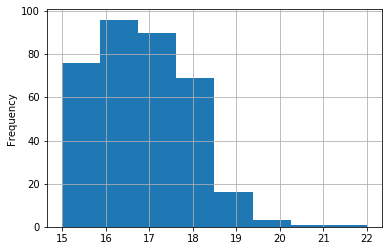

In [25]:
stud['age'].plot(kind = 'hist', grid = True, bins=8)

In [26]:
# Распределение похоже на "обрезанное" нормальное.
# Проверим на выбросы

out = get_outlier(stud,'age')
print('Количество выбросов:', out.count())
display(out)

Количество выбросов: 1


247    22
Name: age, dtype: int64

In [27]:
# Возраст = 22 года является выбросом. Уберем его и проверим распределение на нормальность.

df = stud[stud.age < 22]

u, p_value = normaltest(df.age)
print('normaltest p_value=', p_value)
if p_value > alpha:
    print('По normaltest распределение подобно нормальному')
else:
    print('По normaltest распределение не похоже на нормальное')

normaltest p_value= 0.002862442153038958
По normaltest распределение не похоже на нормальное


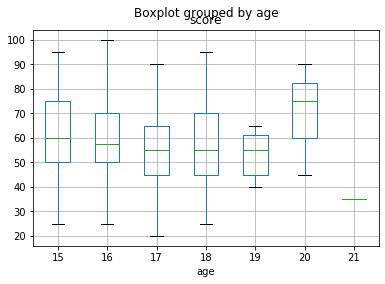

In [28]:
# Посмотрим на сборную box-диаграмму
df.boxplot(column='score', by='age')

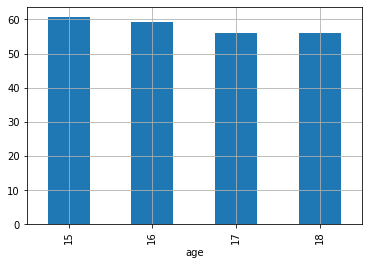

In [29]:
# Cкорее всего, 3 человека возрастом 20 лет учатся осознанно, и их высокие оценки обусловлены
# желанием получить образование в зрелом возрасте. 
# А 2 балбеса возрастом 21 и 22 года - это второгодники с низкими оценками.
# Вообще, возраст более 18 кажется сомнительным, потому что обычно в школе учатся до 18 лет.
# Попробуем убрать возраст старше 18 лет (его и не так много в датасете) и сравнить оценки

df = stud[stud.age <= 18]
df.groupby(by = ['age'])['score'].mean().plot(kind = 'bar', grid= True)

In [30]:
# Похоже, с возрастом оценки в среднем становятся хуже.
# Возможно, появляются другие, более "взрослые" интересы. 
# Вычислим корреляцию возраста с оценками на очищенных данных.

pd.DataFrame(df.age, df.score).reset_index().corr()

,score,age
score,1.000000,-0.119655
age,-0.119655,1.000000


In [31]:
# Кореляция слабая, но все-таки присутствует.
# Чтобы убедиться в зависимости величин, проверим гипотезу независимости разными способами, вычислив p_value
# Корреляция по Спирмену и Кендаллу лучше подходят для шкальных измерений, чем Пирсон.
# У нас как раз шкала: 15, 16, 17, 18.

print('Пирсон p_value =',pearsonr(df['age'], df['score'])[1])
print('Спирмен p_value =',spearmanr(df['age'], df['score'])[1])
print('Кендалл p_value =',kendalltau(df['age'], df['score'])[1])

Пирсон p_value = 0.034099011905442726
Спирмен p_value = 0.02429333375237283
Кендалл p_value = 0.02286436028853191


In [24]:
# Нулевая гипотеза состояла в том, что величины не зависят друг от друга.
# Если p_value больше уровня значимости (возьмем его = 0.05), то нулевая гипотеза подтверждается.
# В данном случае p_value < 0.05, что дает основание принять альтернативную гипотезу: между величинами есть зависимость.

### Вывод для age: зависимость от возраста присутствует

### Столбец Medu

In [32]:
# Medu
# Проверим уникальные и пустые значения

print('Уникальных значений Medu: ' + str(stud.Medu.nunique()))
print('Незаполненных значений Medu: ' + str(len(stud[stud.Medu.isnull()].Medu.index)))
pd.DataFrame(stud.Medu.value_counts())
# Есть с нулевым уровнем образования 3 человека. Возможно, данных об образовании этих людей просто нет

Уникальных значений Medu: 5
Незаполненных значений Medu: 2


,Medu
4.0,125
2.0,88
3.0,87
1.0,47
0.0,3


In [33]:
# Исключим строки с NaN-значениями

df = stud[~stud.Medu.isnull()]

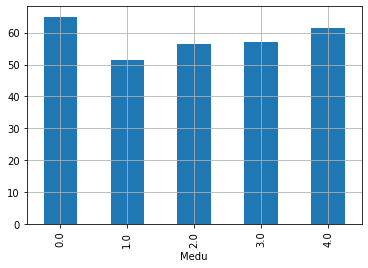

In [34]:
# Посмотрим на распределение оценок по образованию матери
df.groupby(by = ['Medu'])['score'].mean().plot(kind = 'bar', grid= True)

In [36]:
# Выводится странная картина: там, где матери без образования, у детей оценки выше
# Посмотрим на эти записи

df[df.Medu==0]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_granular,higher,internet,romantic,famrel,freetime,goout,health,absences,score
127,GP,F,19,U,GT3,T,0.0,1.0,at_home,other,course,other,1.0,2.0,3.0,no,None,no,no,no,-6.0,no,no,no,3.0,4.0,2.0,5.0,2.0,45.0
249,GP,M,16,U,GT3,T,0.0,2.0,other,other,other,mother,1.0,1.0,0.0,no,no,yes,no,None,-3.0,yes,yes,no,4.0,3.0,2.0,5.0,0.0,75.0
324,GP,F,17,U,LE3,T,0.0,2.0,at_home,at_home,home,father,2.0,3.0,0.0,no,no,no,no,yes,-9.0,yes,yes,no,3.0,3.0,3.0,2.0,0.0,75.0


In [37]:
# Скорее всего, где и у отца низкое образование и у ребенка низкий балл 45 - это реально у матери нет образования
# А там, где у детей высокие баллы = 75, а у родителей или нет образования, или оно невысокое, это ошибочные данные.
# Но для простоты исключим все нулевые значения, тем более, что их количество ничтожно мало.

df = df[df.Medu > 0]

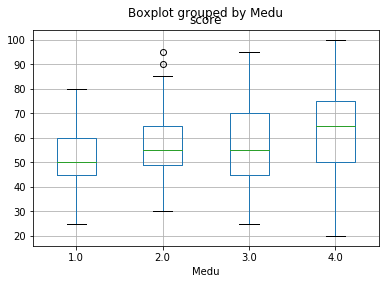

In [38]:
# Посмотрим на сборную box-диаграмму

df.boxplot(column='score', by='Medu')

In [39]:
# Нашлись 2 выброса у Medu=2.0. Удалим их.

df = df[~((df.Medu==2) & (df.score>=90))]

In [40]:
# Составим корреляцию с оценками на почищенных данных.

pd.DataFrame(df.Medu, df.score).reset_index().corr()

,score,Medu
score,1.000000,0.215908
Medu,0.215908,1.000000


In [41]:
# Кореляция невысока, но присутствует.
# Чтобы убедиться в зависимости величин, проверим гипотезу независимости, вычислив p_value.
# Вычислим по Спирмену, так как у нас шкала: 1, 2, 3, 4.

print('Спирмен p_value =',spearmanr(df.Medu, df.score)[1])

Спирмен p_value = 9.23848694032104e-05


In [34]:
# В данном случае p_value < 0.05, что дает основание принять альтернативную гипотезу: между величинами есть зависимость.

### Вывод для Medu: зависимость от образования матери присутствует

### Столбец Fedu

In [42]:
# Fedu
# Проверим уникальные и пустые значения

print('Уникальных значений Fedu: ' + str(stud.Fedu.nunique()))
print('Незаполненных значений Fedu: ' + str(len(stud[stud.Fedu.isnull()].Fedu.index)))
pd.DataFrame(stud.Fedu.value_counts())

# Есть с нулевым образованием 2 человека. Скорее всего, это неизвестное образование.

Уникальных значений Fedu: 6
Незаполненных значений Fedu: 21


,Fedu
2.0,94
3.0,89
4.0,80
1.0,65
0.0,2
40.0,1


In [43]:
# Удалим явно ошибочное значение 40, а также значения NaN.

df = stud[stud.Fedu < 40]

In [44]:
# Проверим на выбросы образование отца

out = get_outlier(df,'Fedu')
print('Количество выбросов:', out.count())
display(out)

Количество выбросов: 2


76     0.0
171    0.0
Name: Fedu, dtype: float64

In [45]:
# Удалим выбросы

df = df[df.Fedu > 0]

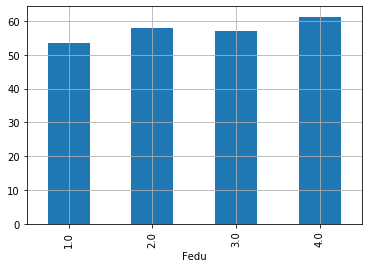

In [46]:
# Посмотрим распределение средних оценок по образованию отца
df.groupby(by = ['Fedu'])['score'].mean().plot(kind = 'bar', grid= True)

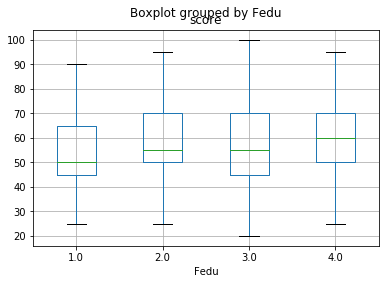

In [47]:
df.boxplot(column='score', by='Fedu')

In [48]:
# Видно, что медианы у Fedu = 2 и 3 совпадают, а средние - нет. Но это не очень важно.
# Однозначно лишь определяется, что оценки более низкие у отцов с начальным образованием,
# а у остальных отцов картина примерно одинаковая.
# Скорее всего, из-за того, что матери больше занимаются с детьми и оказывают большее влияние на ребенка.
# Но, вообще, это признанный факт, что интеллект матери генетически влияет на интеллект ребенка больше, 
# чем интеллект отца, ввиду расположения генов интеллекта на X-хромосоме.

# Проверим значимость по Спирмену.

print('Спирмен p_value =',spearmanr(df.Fedu, df.score)[1])

Спирмен p_value = 0.006319095740639738


In [49]:
# В данном случае p_value < 0.05, что дает основание принять альтернативную гипотезу: между величинами есть зависимость.
# Однако это p_value больше, чем p_value для матерей. 
# То есть, подтвердилась бОльшая значимость образования матери.
# Проверим корреляцию между образованиями матери и отца

df = df[~df.Medu.isnull()]
pd.DataFrame(df.Fedu, df.Medu).reset_index().corr()

,Medu,Fedu
Medu,1.000000,0.849628
Fedu,0.849628,1.000000


In [50]:
# Корреляция на непустых данных очень высокая, что не удивительно, 
# потому что супруги обычно примерно одного уровня образования.
# Столбец Fedu можно исключить. Вместо Fedu достаточно рассмотреть Medu

drop('Fedu')

### Вывод для Fedu: зависимость от образования отца присутствует, но образование отца коррелирует с образованием матери, поэтому столбец исключаем

### Столбец traveltime

In [55]:
# traveltime
# Проверим уникальные и пустые значения

print('Уникальных значений traveltime: ' + str(stud.traveltime.nunique()))
print('Незаполненных значений traveltime: ' + str(len(stud[stud.traveltime.isnull()].traveltime.index)))
pd.DataFrame(stud.traveltime.value_counts())

Уникальных значений traveltime: 4
Незаполненных значений traveltime: 23


,traveltime
1.0,219
2.0,86
3.0,17
4.0,7


In [52]:
# Удалим значения NaN.

df = stud[stud.traveltime >= 0]

In [54]:
# Проверим на выбросы времени до школы

out = get_outlier(df,'traveltime')
print('Количество выбросов:', out.count())
display(out)

Количество выбросов: 7


61     4.0
108    4.0
149    4.0
164    4.0
228    4.0
327    4.0
375    4.0
Name: traveltime, dtype: float64

In [57]:
# Все времена, равные 4, являются выбросами. Удалим их.

df = df[df.traveltime < 4]

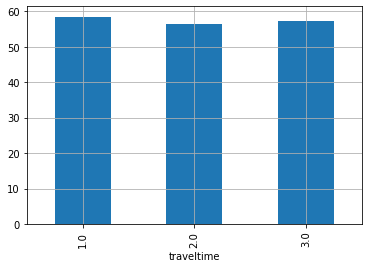

In [58]:
# Посмотрим распределение средних оценок по временам до школы

df.groupby(by = ['traveltime'])['score'].mean().plot(kind = 'bar', grid= True)

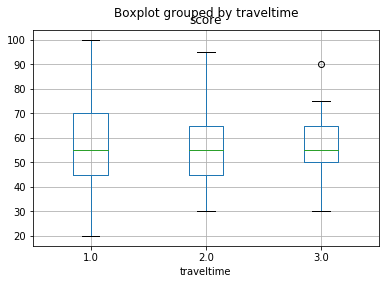

In [59]:
df.boxplot(column='score', by='traveltime')

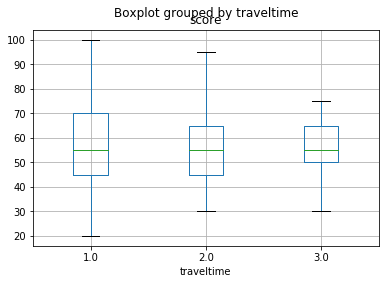

In [60]:
# Уберем выброс у времени = 3.0 для чистоты картины и посмотрим заново

df = df[~((df.score>80) & (df.traveltime==3))]
df.boxplot(column='score', by='traveltime')

In [61]:
# Видно, что при малом времени до школы размах оценок выше.
# Возможно, потому что остается больше свободного времени, которое тратится либо на глупости (оценки низкие),
# либо на учебу (оценки высокие)

# Проверим зависимости
print('Спирмен p_value =',spearmanr(df.traveltime, df.score)[1])
print('Пирсон p_value =',pearsonr(df.traveltime, df.score)[1])
print('Кендалл p_value =',kendalltau(df.traveltime, df.score)[1])
pd.DataFrame(df.traveltime, df.score).reset_index().corr()

Спирмен p_value = 0.24093598006339392
Пирсон p_value = 0.26493918349230955
Кендалл p_value = 0.24447743048158


,score,traveltime
score,1.000000,-0.183528
traveltime,-0.183528,1.000000


In [62]:
# Небольшая корреляция присутствует. Чем меньше времени на дорогу, тем выше оценки. 
# Но тесты на зависимость не пройдены (p_value > 0.05), возможно из-за малого количества значений 3 - их всего 17 (<30).
# Столбец неоднозначный. Однако удалим его.

drop('traveltime')

### Вывод для traveltime: время на дорогу влияет слабо.

### Столбец studytime 

In [64]:
# studytime
# Проверим уникальные и пустые значения

print('Уникальных значений studytime: ' + str(stud.studytime.nunique()))
print('Незаполненных значений studytime: ' + str(len(stud[stud.studytime.isnull()].studytime.index)))
pd.DataFrame(stud.studytime.value_counts())

Уникальных значений studytime: 4
Незаполненных значений studytime: 7


,studytime
2.0,173
1.0,90
3.0,58
4.0,24


In [65]:
# Удалим значения NaN

df = stud[stud.studytime >= 0]

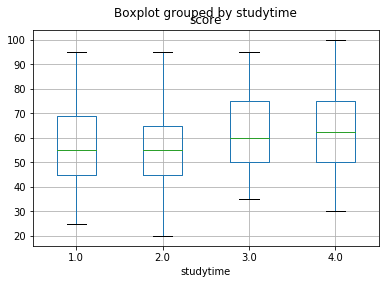

In [66]:
# Проверим график до удаления выбросов

df.boxplot(column='score', by='studytime')

In [68]:
# Явно прорисовываются 2 группы: 1+2 и 3+4
# Проверим на выбросы время учебы

out = get_outlier(df,'studytime')
print('Количество выбросов:', out.count())
display(out)

Количество выбросов: 24


47     4.0
66     4.0
67     4.0
69     4.0
70     4.0
71     4.0
76     4.0
77     4.0
94     4.0
95     4.0
105    4.0
106    4.0
108    4.0
121    4.0
204    4.0
210    4.0
256    4.0
271    4.0
282    4.0
293    4.0
298    4.0
303    4.0
330    4.0
338    4.0
Name: studytime, dtype: float64

In [70]:
# Все времена, равные 4, являются выбросами. 
# Но раз их много, то не будем удалять их, а объединим по группам, добавив столбец

stud['gr_studytime'] = stud.studytime.apply(lambda x: None if x is None else 0 if x<3 else 1)
df = stud[stud.studytime >= 0]

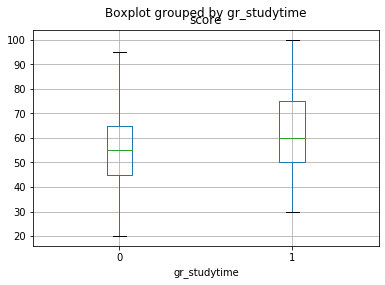

In [71]:
# Посмотрим на график по группам

df.boxplot(column='score', by='gr_studytime')

In [72]:
# Проверим зависимости для групп

print('Спирмен p_value =',spearmanr(df.gr_studytime, df.score)[1])
print('Пирсон p_value =',pearsonr(df.gr_studytime, df.score)[1])
print('Кендалл p_value =',kendalltau(df.gr_studytime, df.score)[1])
pd.DataFrame(df.gr_studytime, df.score).reset_index().corr()

Спирмен p_value = 0.0013449807221124514
Пирсон p_value = 0.0005317170077041298
Кендалл p_value = 0.001426420948164652


,score,gr_studytime
score,1.000000,0.465512
gr_studytime,0.465512,1.000000


In [74]:
# Зависимость очень отчетливая по всем тестам. 
# Если тратить на уроки 3 и более часов времени, то оценки становятся лучше
# Оставим столбец с группами урочных часов (gr_studytime), а исходный столбец (studytime) удалим

drop('studytime')

### Вывод для studytime: время на уроки влияет на оценки 

### Столбец failures 

In [75]:
# failures
# Проверим уникальные и пустые значения

print('Уникальных значений failures: ' + str(stud.failures.nunique()))
print('Незаполненных значений studytime: ' + str(len(stud[stud.failures.isnull()].failures.index)))
pd.DataFrame(stud.failures.value_counts())

Уникальных значений failures: 4
Незаполненных значений studytime: 20


,failures
0.0,273
1.0,38
2.0,11
3.0,10


In [76]:
# Удалим значения NaN

df = stud[stud.failures >= 0]

In [77]:
# Проверим на выбросы количества неудач

out = get_outlier(df,'failures')
print('Количество выбросов:', out.count())
display(out.head(10))

Количество выбросов: 59


2     3.0
18    3.0
25    2.0
40    1.0
44    1.0
49    1.0
52    1.0
72    2.0
78    3.0
85    2.0
Name: failures, dtype: float64

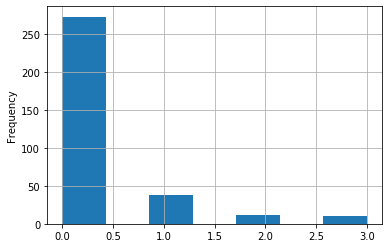

In [78]:
# Очень много выбросов! Посмотрим на гистограмму
df.failures.plot(kind = 'hist', grid = True, bins = 7)

In [79]:
# Все ненулевые оценки являются выбросами!
# Преобразуем, снова сгруппировав данные в отдельный столбец. Иначе без выбросов останется единственное значение

stud['gr_failures'] = stud.failures.apply(lambda x: None if x is None else 0 if x==0 else 1)
df = stud[stud.failures >= 0]

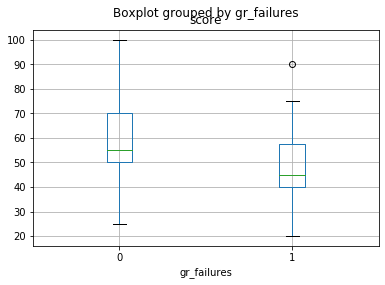

In [80]:
# Посмотрим на график по группам

df.boxplot(column='score', by='gr_failures')

In [81]:
# Уберем выброс для группы 1 и проверим зависимости для групп

df = df[~((df.score>80) & (df.gr_failures==1))]

print('Спирмен p_value =',spearmanr(df.gr_failures, df.score)[1])
print('Пирсон p_value =',pearsonr(df.gr_failures, df.score)[1])
print('Кендалл p_value =',kendalltau(df.gr_failures, df.score)[1])
pd.DataFrame(df.gr_failures, df.score).reset_index().corr()

Спирмен p_value = 2.344725962733338e-08
Пирсон p_value = 4.737826056757574e-08
Кендалл p_value = 4.5803237508662445e-08


,score,gr_failures
score,1.000000,-0.194461
gr_failures,-0.194461,1.000000


In [83]:
# Корреляционные тесты показывают серьезную зависимость оценок от наличия неудач
# Столбец с количеством неудач (failures) удалим, но оставим столбец для групп неудач (failures)

drop('failures')

### Вывод для failures:  на оценки влияет не количество, а наличие неудач

### Столбец famrel 

In [84]:
# famrel
# Проверим уникальные и пустые значения

print('Уникальных значений famrel: ' + str(stud.famrel.nunique()))
print('Незаполненных значений famrel: ' + str(len(stud[stud.famrel.isnull()].famrel.index)))
pd.DataFrame(stud.famrel.value_counts())

Уникальных значений famrel: 6
Незаполненных значений famrel: 24


,famrel
4.0,163
5.0,88
3.0,56
2.0,14
1.0,6
-1.0,1


In [86]:
# Значение -1 - ошибочное. Уберем его и NaN

df = stud[stud.famrel > 0]

In [87]:
# Проверим на выбросы семейные отношения

out = get_outlier(df,'famrel')
print('Количество выбросов:', out.count())
display(out.head(10))

Количество выбросов: 20


27     2.0
37     2.0
46     2.0
60     2.0
66     1.0
79     2.0
108    1.0
141    2.0
156    2.0
184    1.0
Name: famrel, dtype: float64

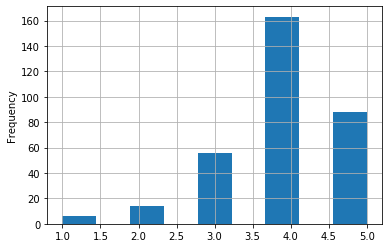

In [88]:
# Очень много выбросов! Посмотрим на графики
df.famrel.plot(kind = 'hist', grid = True, bins = 9)

In [89]:
# Удалим выбросы

df = df[df.famrel > 2]

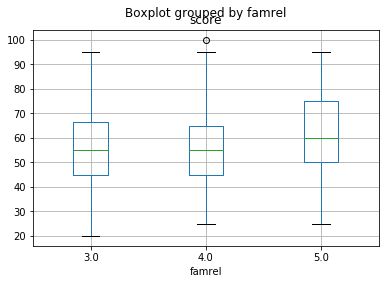

In [90]:
df.boxplot(column='score', by='famrel')

In [91]:
# Уберем выброс для значения 4 и проверим зависимости

df = df[~((df.score==100) & (df.famrel==1))]

print('Спирмен p_value =',spearmanr(df.famrel, df.score)[1])
print('Пирсон p_value =',pearsonr(df.famrel, df.score)[1])
print('Кендалл p_value =',kendalltau(df.famrel, df.score)[1])

Спирмен p_value = 0.10502685766681082
Пирсон p_value = 0.1300896605061115
Кендалл p_value = 0.10749257413210044


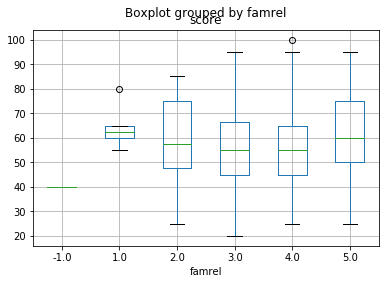

In [93]:
# По результатам тестов зависимость оценок от отношений в семье для диапазона от средних до отличных - отсутствует
# Для выяснения зависимости от полного спектра отношений не хватает данных по плохим отношениям
# Посмотрим на график со всеми отношениями:

stud.boxplot(column='score', by='famrel')

In [94]:
# Полный график демонстрирует примерно одинаковые медианные оценки и похожий размах. Удалим столбец

drop('famrel')

### Вывод для famrel: отношения в семье не влияют на оценки

### Столбец freetime 

In [95]:
# freetime
# Проверим уникальные и пустые значения

print('Уникальных значений freetime: ' + str(stud.freetime.nunique()))
print('Незаполненных значений freetime: ' + str(len(stud[stud.freetime.isnull()].freetime.index)))
pd.DataFrame(stud.freetime.value_counts())

Уникальных значений freetime: 5
Незаполненных значений freetime: 8


,freetime
3.0,132
4.0,102
2.0,59
5.0,35
1.0,16


In [96]:
# Уберем NaN
df = stud[stud.freetime > 0]

In [97]:
# Проверим на выбросы свободное время

out = get_outlier(df,'freetime')
print('Количество выбросов:', out.count())
display(out.head(10))

Количество выбросов: 16


7      1.0
19     1.0
68     1.0
89     1.0
95     1.0
106    1.0
111    1.0
112    1.0
189    1.0
238    1.0
Name: freetime, dtype: float64

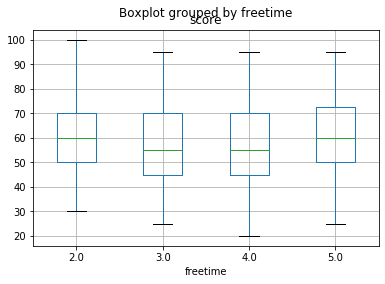

In [98]:
# Уберем выбросы и построим график

df = df[df.freetime > 1]
df.boxplot(column='score', by='freetime')

In [99]:
# Проверим статистику по Спирмену (так как шкальный интервал)

print('Спирмен p_value =',spearmanr(df.freetime, df.score)[1])

Спирмен p_value = 0.42479412633666336


In [100]:
# Результат совпадает с графиком: объем свободного времени не влияет на оценки
# Удалим столбец

drop('freetime')

### Вывод для freetime: количество свободного времени не влияет на оценки 

### Столбец goout 

In [101]:
# goout
# Проверим уникальные и пустые значения

print('Уникальных значений goout: ' + str(stud.goout.nunique()))
print('Незаполненных значений goout: ' + str(len(stud[stud.goout.isnull()].goout.index)))
pd.DataFrame(stud.goout.value_counts())

Уникальных значений goout: 5
Незаполненных значений goout: 6


,goout
3.0,118
2.0,92
4.0,74
5.0,43
1.0,19


In [102]:
# Уберем NaN и проверим на выбросы

df = stud[stud.goout > 0]

out = get_outlier(df,'goout')
print('Количество выбросов:', out.count())
display(out.head(10))

Количество выбросов: 0


Series([], Name: goout, dtype: float64)

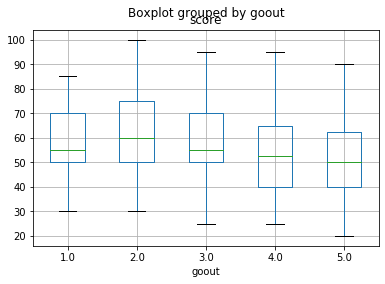

In [103]:
# Построим график

df.boxplot(column='score', by='goout')

In [104]:
# Если слишком много времени проводить с друзьями, то оценки снижаются.
# Но и полное игнорирование друзей (значение = 1.0) тоже снижает оценки.

# Проверим статистику по Спирмену (так как шкальный интервал)

print('Спирмен p_value =',spearmanr(df.goout, df.score)[1])

Спирмен p_value = 0.0004028891842706913


In [105]:
# Корреляционный тест подтвердил значимость свободного времени для оценок (p_value < 0.05)

# Интересно узнать зависимость между свободным временем, временем на дорогу, временем для друзей и временем на учебу
# Сравним значения столбцов
df = stud[(stud.score > 0) & (~stud.studytime.isnull()) & (~stud.freetime.isnull()) 
          & (~stud.traveltime.isnull()) & (~stud.goout.isnull())]
np.corrcoef([df['score'], df['studytime'], df['freetime'], df['traveltime'], df['goout']])

array([[ 1.        ,  0.10781754, -0.04216901, -0.06596497, -0.22786668],
       [ 0.10781754,  1.        , -0.13591798, -0.09244826, -0.01482561],
       [-0.04216901, -0.13591798,  1.        , -0.01834493,  0.30278379],
       [-0.06596497, -0.09244826, -0.01834493,  1.        ,  0.05008533],
       [-0.22786668, -0.01482561,  0.30278379,  0.05008533,  1.        ]])

In [89]:
# Корреляция присутствует, хоть и слабая. Чем меньше времени на дорогу или на свободные занятия или на друзей, 
# тем больше времени на учебу и лучше оценки.
# Больше всего влияет на оценки излишне свободное время (оно не тратится на уроки).
# Хорошо видно, что свободное время часто тратится на друзей (самая сильная корреляция в матрице).

### Вывод для goout: время, которое тратится на общение с друзьями, значимо для оценок

### Столбец health 

In [107]:
# health
# Проверим уникальные и пустые значения

print('Уникальных значений health: ' + str(stud.health.nunique()))
print('Незаполненных значений health: ' + str(len(stud[stud.health.isnull()].health.index)))
pd.DataFrame(stud.health.value_counts())

Уникальных значений health: 5
Незаполненных значений health: 13


,health
5.0,124
3.0,81
4.0,53
1.0,45
2.0,36


In [108]:
# Уберем NaN и проверим на выбросы

df = stud[stud.health > 0]

out = get_outlier(df,'health')
print('Количество выбросов:', out.count())
display(out.head(10))

Количество выбросов: 0


Series([], Name: health, dtype: float64)

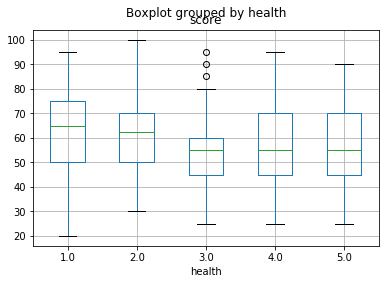

In [109]:
# Построим график

df.boxplot(column='score', by='health')

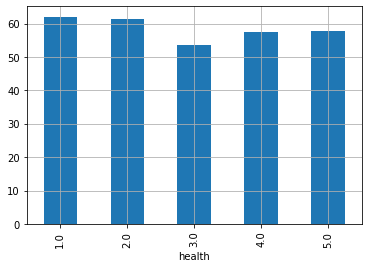

In [110]:
# Удалим выбросы у значения 3.0 и построим график средних

df = df[~((df.score>80) & (df.health==3))]
df.groupby(by = ['health'])['score'].mean().plot(kind = 'bar', grid= True)

In [112]:
# Столбец влияет на оценки, но не однозначно.
# Если слабое здоровье, то ученик компенсирует его за счет более усердной учебы, и оценки улучшаются.
# Если отличное здоровье, то некоторые ученики имеют хорошие оценки за счет здоровья,
# а некоторые слишком много времени резвятся и плюют на учебу.

# Проверим статистику

print('Спирмен p_value =',spearmanr(df.health, df.score)[1])

Спирмен p_value = 0.425447522004362


In [114]:
# Снова можно выделить две группы: слабое и сильное здоровье

stud['gr_health'] = stud.health.apply(lambda x: None if x is None else 0 if x<3 else 1)
df = stud[stud.health >= 0]

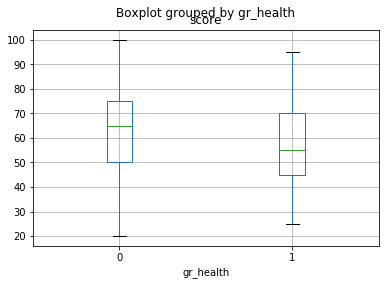

In [115]:
# Построим график для групп

df.boxplot(column='score', by='gr_health')

In [116]:
# Проверим статистику

print('Спирмен p_value =',spearmanr(df.gr_health, df.score)[1])

Спирмен p_value = 0.024700255432963582


In [117]:
# p_value < 0.05, что означает - группы здоровья статистически значимы для оценок
# Конкретные степени здоровья влияют меньше, чем просто градация "Слабое/Крепкое"
# Удалим столбец health и оставим группы здровья

drop('health')

### Вывод для health: на оценки влияют укрупненные группы здоровья 

### Столбец absences 

In [118]:
# absences
# Проверим уникальные и пустые значения

print('Уникальных значений absences: ' + str(stud.absences.nunique()))
print('Незаполненных значений absences: ' + str(len(stud[stud.absences.isnull()].absences.index)))
pd.DataFrame(stud.absences.value_counts()).head(10)

Уникальных значений absences: 36
Незаполненных значений absences: 10


,absences
0.0,74
2.0,60
4.0,52
6.0,30
8.0,20
10.0,17
12.0,12
14.0,12
3.0,7
16.0,7


In [119]:
# Уберем NaN и проверим на выбросы

df = stud[stud.absences > 0]

out = get_outlier(df,'absences')
print('Количество выбросов:', out.count())
display(out)

Количество выбросов: 17


40      25.0
74      54.0
103     26.0
183     56.0
198     24.0
205     28.0
216     22.0
222    385.0
260     21.0
276     75.0
277     22.0
280     30.0
307     38.0
313     22.0
315     40.0
320     23.0
390    212.0
Name: absences, dtype: float64

In [120]:
# Удалим выбросы
df = df[~(df.absences.isin(out.tolist()))]

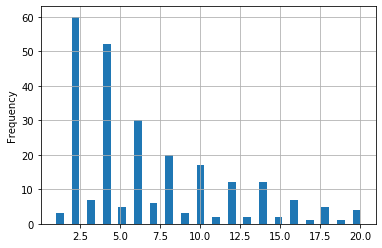

In [121]:
# Посмотрим, как значения распределяются

df.absences.plot(kind = 'hist', grid = True, bins=(df.absences.nunique()*2 - 1))

In [122]:
# Видно, что нечетные значения как бы проваливаются между четными.
# Соединим нечетные значения с ближайшим большим четным и снова найдем выбросы.

stud.absences = stud.absences.apply(lambda x: x+1 if x%2==1 else x)

df = stud[stud.absences > 0]

out = get_outlier(df,'absences')
print('Количество выбросов:', out.count())
display(out)

Количество выбросов: 22


40      26.0
74      54.0
103     26.0
118     20.0
183     56.0
198     24.0
205     28.0
216     22.0
222    386.0
237     20.0
260     22.0
276     76.0
277     22.0
280     30.0
281     20.0
304     20.0
307     38.0
311     20.0
313     22.0
315     40.0
320     24.0
390    212.0
Name: absences, dtype: float64

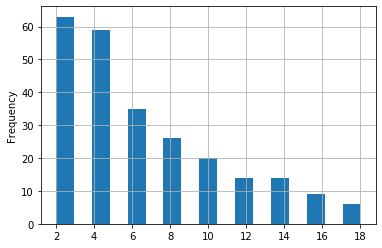

In [124]:
# Снова построим график

df = df[~(df.absences.isin(out.tolist()))]
df.absences.plot(kind = 'hist', grid = True, bins=(df.absences.nunique()*2 - 1))

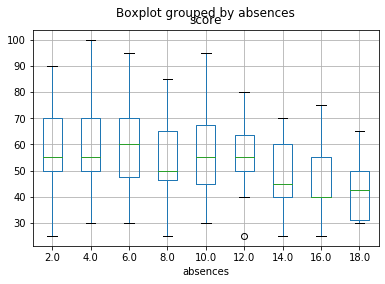

In [126]:
# Получилась половинка нормального распределения
# Посмотрим на box-графики

df.boxplot(column='score', by='absences')

In [128]:
# Видно, что чем больше пропусков, тем приблизительно ниже оценки.
# Удалим выбросы у значения 12.0 и проверим корреляцию по Пирсону, так как у нас непрерывный, а не шкальный интервал

df = df[~((df.score<30) & (df.absences==12))]
print('Пирсон p_value =',pearsonr(df.absences, df.score)[1])

Пирсон p_value = 0.001508291989465615


In [108]:
# P_value < 0.05, что означает статистическую значимость пропусков для оценок

### Вывод для absences: пропуски влияют на оценки 

# Анализ номинативных столбцов

### Столбец school

In [129]:
# school
# Проверим уникальные и пустые значения

print('Уникальных значений school: ' + str(stud.school.nunique()))
print('Незаполненных значений school: ' + str(len(stud[stud.school.isnull()].school.index)))
pd.DataFrame(stud.school.value_counts())

Уникальных значений school: 2
Незаполненных значений school: 0


,school
GP,311
MS,41


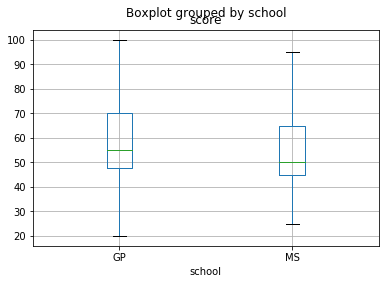

In [130]:
# Все данные по школам заполнены, пустых значений нет
# Проверим распределение на графике

stud.boxplot(column='score', by='school')

In [132]:
# Видно, что в одной школе оценки в среднем выше и размах выше. 
# Это соответствует здравому смыслу: бывают сильные и бывают слабые школы.
# Тем не менее, проверим статистически зависимость, 
# построив нулевую гипотезу: распределение двух выборок оценок по разным школам не отличается.
# В обеих выборках > 30 человек, поэтому можно проверять статистику.

# Проверим двумя критериями: Стьюдента (для нормального распределения) и Манна-Уитни (для не нормального)
# Так как у нас распределение лишь условно нормальное, попробуем проверить оба критерия.

print(get_stat_dif(stud, 'school', 'score', True))
print(get_stat_dif(stud, 'school', 'score', False))

Для порога 0.05 по критерию Стьюдента значимости нет: min(p_value) = 0.14278913636690213
Для порога 0.05 по критерию Манна-Уитни значимости нет: min(p_value) = 0.06769027331611666


In [133]:
# Так как полученное p_value > 0.05, можно считать, что все-таки нулевая гипотеза не отвергается,
# и от школы оценки не зависят. Столбец school можно удалить.

drop('school')

### Вывод для school: статистической значимости оценок от школы нет

### Столбец sex

In [134]:
# sex
# Проверим уникальные и пустые значения

print('Уникальных значений sex: ' + str(stud.sex.nunique()))
print('Незаполненных значений sex: ' + str(len(stud[stud.sex.isnull()].sex.index)))
pd.DataFrame(stud.sex.value_counts())

Уникальных значений sex: 2
Незаполненных значений sex: 0


,sex
F,182
M,170


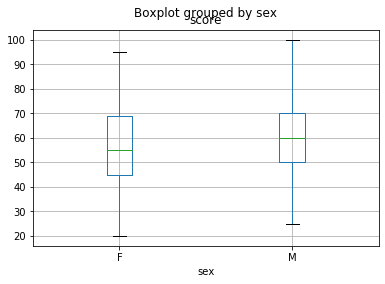

In [135]:
# Пол указан у всех учеников, пустых значений нет
# Проверим распределение на графике

stud.boxplot(column='score', by='sex')

In [137]:
# Визуально кажется, что оценки у мальчиков чуть выше, чем у девочек.
# Проверим статистически эти различия двумя разными критериями

print(get_stat_dif(stud, 'sex', 'score', True))
print(get_stat_dif(stud, 'sex', 'score', False))

Для порога 0.05 по критерию Стьюдента значимости нет: min(p_value) = 0.05481629433224236
Для порога 0.05 по критерию Манна-Уитни значимость есть: для ('F', 'M') p_value = 0.039994416374666206


In [135]:
# Тест Манна-Уитни сообщил, что значимые различия присутствуют.
# Зависимость оценок от пола балансирует на грани 0.05
# Возможно, по другим предметам оценки были бы независимы от пола, 
# но аналитический предмет (математика) юношам дается чуть лучше, чем девушкам

### Вывод для sex: оценки очень слабо, но все же зависят от пола

### Столбец address 

In [138]:
# address
# Проверим уникальные и пустые значения

print('Уникальных значений address: ' + str(stud.address.nunique()))
print('Незаполненных значений address: ' + str(len(stud[stud.address.isnull()].address.index)))
pd.DataFrame(stud.address.value_counts())

Уникальных значений address: 2
Незаполненных значений address: 14


,address
U,265
R,73


In [139]:
# Удалим строки с пустыми адресами

df = stud[~stud.address.isnull()]

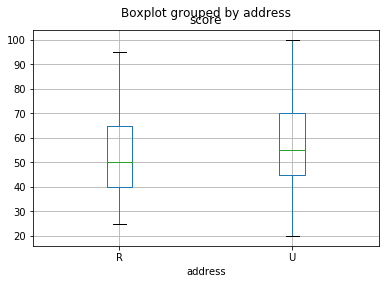

In [140]:
# Проверим распределение на графике

df.boxplot(column='score', by='address')

In [141]:
# Визуально кажется, что у городских учеников оценки повыше
# Проверим разными тестами статистическую значимость 

print(get_stat_dif(df, 'address', 'score', True))
print(get_stat_dif(df, 'address', 'score', False))

Для порога 0.05 по критерию Стьюдента значимость есть: для ('U', 'R') p_value = 0.010954630500627841
Для порога 0.05 по критерию Манна-Уитни значимость есть: для ('U', 'R') p_value = 0.005797249695971091


In [140]:
# Оба теста показали маленькое значение p_value < 0.05.
# Значит, от места проживания оценки зависят. 
# У сельских учеников, вероятно, больше дел по хозяйству и меньше мотивации.

### Вывод для address: оценки зависят от места проживания 

### Столбец famsize

In [142]:
# famsize
# Проверим уникальные и пустые значения

print('Уникальных значений famsize: ' + str(stud.famsize.nunique()))
print('Незаполненных значений famsize: ' + str(len(stud[stud.famsize.isnull()].famsize.index)))
pd.DataFrame(stud.famsize.value_counts())

Уникальных значений famsize: 2
Незаполненных значений famsize: 24


,famsize
GT3,228
LE3,100


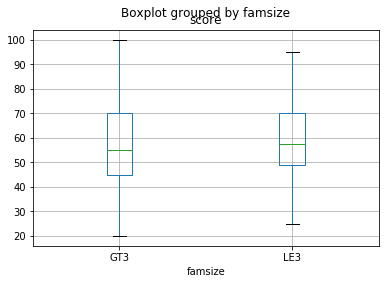

In [143]:
# Удалим строки с пустыми значениями и проверим распределение на графике

df = stud[~stud.famsize.isnull()]
df.boxplot(column='score', by='famsize')

In [144]:
# Медианы и Q3 примерно равны. Но у малодетных оценки покомпактнее
# Можно предположить, что в большой семье начинает работать естественный отбор:
# сильные еще более закаляются, а слабые опускаются.
# А в малодетной семье внимания к детям больше, и детей излишне опекают, но и не дают опуститься.

# Проверим двумя критериями 

print(get_stat_dif(df, 'famsize', 'score', True))
print(get_stat_dif(df, 'famsize', 'score', False))

Для порога 0.05 по критерию Стьюдента значимости нет: min(p_value) = 0.6456316209263082
Для порога 0.05 по критерию Манна-Уитни значимости нет: min(p_value) = 0.36597811098233085


In [145]:
# Все тесты единодушны: p_value > 0.05 и размер семьи на оценки не влияет
# Удалим столбец famsize

drop('famsize')

### Вывод для famsize: размер семьи на оценки не влияет

### Столбец Pstatus

In [146]:
# Pstatus
# Проверим уникальные и пустые значения

print('Уникальных значений Pstatus: ' + str(stud.Pstatus.nunique()))
print('Незаполненных значений Pstatus: ' + str(len(stud[stud.Pstatus.isnull()].Pstatus.index)))
pd.DataFrame(stud.Pstatus.value_counts())

Уникальных значений Pstatus: 2
Незаполненных значений Pstatus: 41


,Pstatus
T,277
A,34


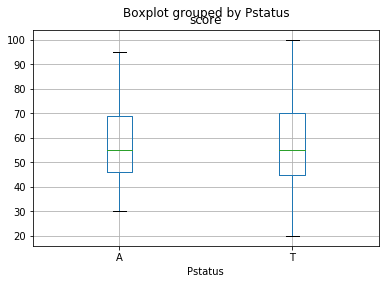

In [147]:
# Удалим строки с пустыми значениями и проверим распределение на графике

df = stud[~stud.Pstatus.isnull()]
df.boxplot(column='score', by='Pstatus')

In [149]:
# Визуально данные не сильно отличаются
# Проверим двумя критериями 

print(get_stat_dif(df, 'Pstatus', 'score', True))
print(get_stat_dif(df, 'Pstatus', 'score', False))

Для порога 0.05 по критерию Стьюдента значимости нет: min(p_value) = 0.761856873862071
Для порога 0.05 по критерию Манна-Уитни значимости нет: min(p_value) = 0.4519072193221277


In [150]:
# Все тесты единодушны: p_value > 0.05 (и даже близки к 1) и совместное проживание родителей на оценки не влияет
# Удалим столбец Pstatus

drop('Pstatus')

### Вывод для Pstatus: совместное или раздельное проживание родителей на оценки не влияет 

### Столбец Mjob 

In [151]:
# Mjob 
# Проверим уникальные и пустые значения

print('Уникальных значений Mjob: ' + str(stud.Mjob.nunique()))
print('Незаполненных значений Mjob: ' + str(len(stud[stud.Mjob.isnull()].Mjob.index)))
pd.DataFrame(stud.Mjob.value_counts())

Уникальных значений Mjob: 5
Незаполненных значений Mjob: 17


,Mjob
other,115
services,90
teacher,51
at_home,49
health,30


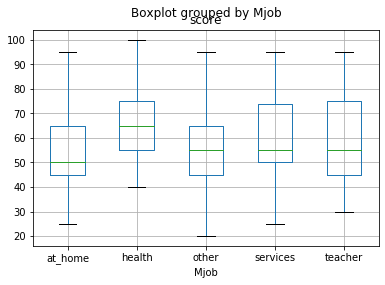

In [152]:
# Удалим строки с пустыми значениями и проверим распределение на графике

df = stud[~stud.Mjob.isnull()]
df.boxplot(column='score', by='Mjob')

In [153]:
# По графику видно, что оценки для разных групп профессий матерей отличаются
# Проверим выборки двумя критериями 

print(get_stat_dif(df, 'Mjob', 'score', True))
print(get_stat_dif(df, 'Mjob', 'score', False))

Для порога 0.005 по критерию Стьюдента значимость есть: для ('other', 'health') p_value = 0.0017949217915780725
Для порога 0.005 по критерию Манна-Уитни значимость есть: для ('other', 'health') p_value = 0.0016007156420228517


In [154]:
# Тесты показывают значимость
# Попробуем дополнительно проверить зависимость образования от группы профессий матерей

df = df[df.Medu >= 0]
spearmanr(df.Mjob, df.Medu)[1]

9.333363204656108e-17

In [155]:
# p_value почти равно нулю!
# Скорее всего, профессия матери зависит от образования, и достаточно оставить один столбец - Medu
# Но нет понимания, как именно влияет, поэтому оставим оба столбца

### Вывод для столбца Mjob: он оказывает влияние на оценки

### Столбец Fjob

In [156]:
# Fjob 
# Проверим уникальные и пустые значения

print('Уникальных значений Fjob: ' + str(stud.Fjob.nunique()))
print('Незаполненных значений Fjob: ' + str(len(stud[stud.Fjob.isnull()].Fjob.index)))
pd.DataFrame(stud.Fjob.value_counts())

Уникальных значений Fjob: 5
Незаполненных значений Fjob: 32


,Fjob
other,176
services,89
teacher,26
health,15
at_home,14


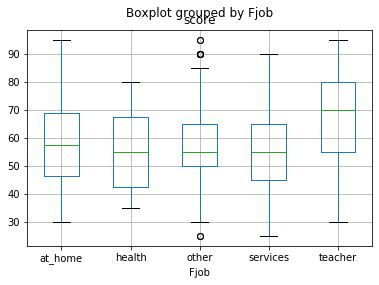

In [157]:
# Удалим строки с пустыми значениями и проверим распределение на графике

df = stud[~stud.Fjob.isnull()]
df.boxplot(column='score', by='Fjob')

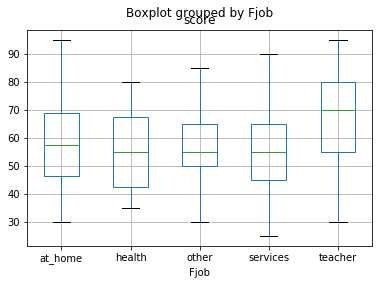

In [158]:
# Обнаружились выбросы у группы 'other'. Удалим их

df = df[~((df.Fjob=='other') & ((df.score>=90) | (df.score<30)))]
df.boxplot(column='score', by='Fjob')

In [159]:
# По графику видно, что оценки для разных групп профессий отцов отличаются только в плане Учитель/Не учитель
# Проверим двумя критериями 

print(get_stat_dif(df, 'Fjob', 'score', True))
print(get_stat_dif(df, 'Fjob', 'score', False))

Для порога 0.005 по критерию Стьюдента значимость есть: для ('other', 'teacher') p_value = 0.0001953244096575503
Для порога 0.005 по критерию Манна-Уитни значимость есть: для ('other', 'teacher') p_value = 0.000706587890741815


In [160]:
# Попробуем убрать профессию "Учитель" и проверить зависимость без нее

df1 = df[df.Fjob != 'teacher']

print(get_stat_dif(df1, 'Fjob', 'score', True))
print(get_stat_dif(df1, 'Fjob', 'score', False))

Для порога 0.008333333333333333 по критерию Стьюдента значимости нет: min(p_value) = 0.3043525075033831
Для порога 0.008333333333333333 по критерию Манна-Уитни значимости нет: min(p_value) = 0.23712393222245903


In [161]:
# Выходит, значимость придавало только то, что отец - учитель или не учитель
# Попробуем также разделить на 2 группы: учитель и не учитель

stud['gr_Fjob'] = stud.Fjob.apply(lambda x: None if x is None else 1 if x=='teacher' else 0)

df = stud[~stud.Fjob.isnull()]
df = df[~((df.Fjob=='other') & ((df.score>=90) | (df.score<30)))]

print('Спирмен p_value =', spearmanr(df.gr_Fjob, df.score)[1])

Спирмен p_value = 0.0015111405965573831


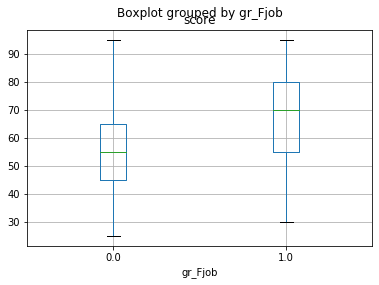

In [162]:
# Зависимость видна и на графике

df.boxplot(column='score', by='gr_Fjob')

In [163]:
# Просто из любопытства посмотрим, есть ли зависимость от профессии матери

df1 = df[~df.Mjob.isnull()]
spearmanr(df1.Mjob, df1.Fjob)[1]

9.903311586804573e-05

In [164]:
# Зависимость есть, но непонятно, как ее интерпретировать.

# Для дальнейшей модели можно удалить столбец Fjob и заменить его на gr_Fjob

drop('Fjob')

### Вывод для столбца Fjob: не все профессии отца оказывают влияние на оценки. Влияет лишь то, что отец - учитель или не учитель.

### Столбец reason 

In [166]:
# reason
# Проверим уникальные и пустые значения

print('Уникальных значений reason: ' + str(stud.reason.nunique()))
print('Незаполненных значений reason: ' + str(len(stud[stud.reason.isnull()].reason.index)))
pd.DataFrame(stud.reason.value_counts())

Уникальных значений reason: 4
Незаполненных значений reason: 15


,reason
course,119
reputation,96
home,89
other,33


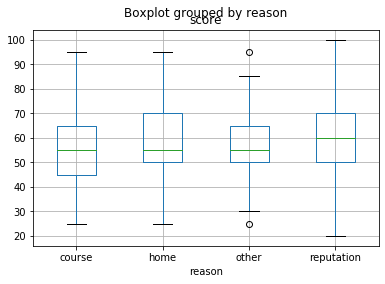

In [167]:
# Удалим строки с пустыми значениями и проверим распределение на графике

df = stud[~stud.reason.isnull()]
df.boxplot(column='score', by='reason')

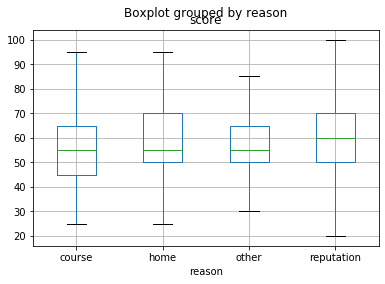

In [168]:
# Обнаружились выбросы у группы 'other'. Удалим их

df = df[~((df.reason=='other') & ((df.score>90) | (df.score<30)))]
df.boxplot(column='score', by='reason')

In [169]:
# По графику видно, что только репутация школы немного повышает оценки, но в целом зависимости нет.
# Проверим попарные выборки двумя критериями 

print(get_stat_dif(df, 'reason', 'score', True))
print(get_stat_dif(df, 'reason', 'score', False))

Для порога 0.008333333333333333 по критерию Стьюдента значимости нет: min(p_value) = 0.2532160066369303
Для порога 0.008333333333333333 по критерию Манна-Уитни значимости нет: min(p_value) = 0.10760727306072915


In [170]:
# Удалим столбец

drop('reason')

### Вывод для столбца reason: он не влияет на оценку

### Столбец guardian

In [171]:
# guardian
# Проверим уникальные и пустые значения

print('Уникальных значений guardian: ' + str(stud.guardian.nunique()))
print('Незаполненных значений guardian: ' + str(len(stud[stud.guardian.isnull()].guardian.index)))
pd.DataFrame(stud.guardian.value_counts())

Уникальных значений guardian: 3
Незаполненных значений guardian: 29


,guardian
mother,225
father,78
other,20


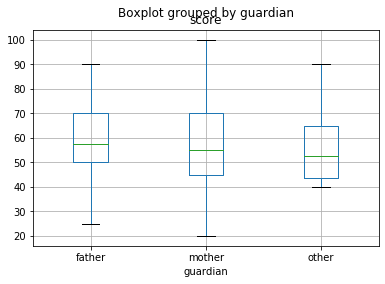

In [175]:
# Удалим строки с пустыми значениями и проверим распределение на графике

df = stud[~stud.guardian.isnull()]
df.boxplot(column='score', by='guardian')

In [176]:
# Визуально данные отличаются: если опекун - не родной родитель, то оценки немного ниже
# И еще видно, что матери чуть похуже следят за детьми, чем другие опекуны
# Проверим cтатистическую значимость

print(get_stat_dif(df, 'guardian', 'score', True))
print(get_stat_dif(df, 'guardian', 'score', False))

Для порога 0.016666666666666666 по критерию Стьюдента значимости нет: min(p_value) = 0.2773071542197519
Для порога 0.016666666666666666 по критерию Манна-Уитни значимости нет: min(p_value) = 0.09535389769105046


In [177]:
# Для трех групп не найдена статистическая значимость.
# Скорее всего, это связано с пренебрежительно малым размером группы "other" (<30) 
# и одновременно примерно одинаковой картиной для "father" и "mother"

# Удалим столбец

drop('guardian')

### Вывод для столбца guardian: он почти не влияет на оценки

### Столбец schoolsup 

In [178]:
# schoolsup
# Проверим уникальные и пустые значения

print('Уникальных значений schoolsup: ' + str(stud.schoolsup.nunique()))
print('Незаполненных значений schoolsup: ' + str(len(stud[stud.schoolsup.isnull()].schoolsup.index)))
pd.DataFrame(stud.schoolsup.value_counts())

Уникальных значений schoolsup: 2
Незаполненных значений schoolsup: 9


,schoolsup
no,295
yes,48


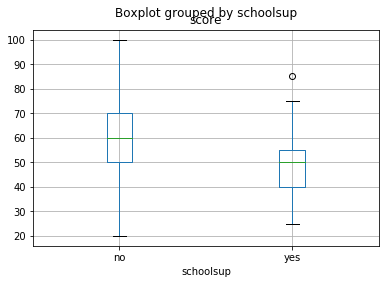

In [179]:
# Удалим строки с пустыми значениями и проверим распределение на графике

df = stud[~stud.schoolsup.isnull()]
df.boxplot(column='score', by='schoolsup')

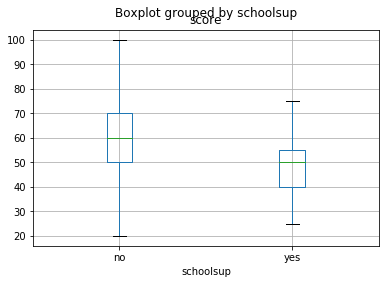

In [180]:
# Уберем выбросы для значения yes

df = df[~((df.schoolsup=='yes') & (df.score>80))]
df.boxplot(column='score', by='schoolsup')

In [182]:
# Визуально данные отличаются: если есть поддержка в школе, то оценки ниже
# Картина кажется странной - есть помощь, а оценки ниже
# Протестируем выборки

print(get_stat_dif(df, 'schoolsup', 'score', True))
print(get_stat_dif(df, 'schoolsup', 'score', False))

Для порога 0.05 по критерию Стьюдента значимость есть: для ('no', 'yes') p_value = 6.34088672972889e-07
Для порога 0.05 по критерию Манна-Уитни значимость есть: для ('no', 'yes') p_value = 5.654178025145872e-07


In [176]:
# Наличие поддержки очень значимо. Но здравый смысл подсказывает, что зависимость обратная:
# тем, кто хуже учится, оказывают больше поддержки и поддержка в школе - это производная от оценок
# Надо удалить столбец, так как он зависим от оценки, а не наоборот.
# Но так как нет уверенности в том, что в датасете не перепутаны значения yes и no, то оставим.

### Вывод для schoolsup: значимость поддержки для оценок присутствует. Хотя, скорее, наоборот - присутствует значимость оценок для поддержки 

### Столбец famsup 

In [183]:
# famsup
# Проверим уникальные и пустые значения

print('Уникальных значений famsup: ' + str(stud.famsup.nunique()))
print('Незаполненных значений famsup: ' + str(len(stud[stud.famsup.isnull()].famsup.index)))
pd.DataFrame(stud.famsup.value_counts())

Уникальных значений famsup: 2
Незаполненных значений famsup: 36


,famsup
yes,196
no,120


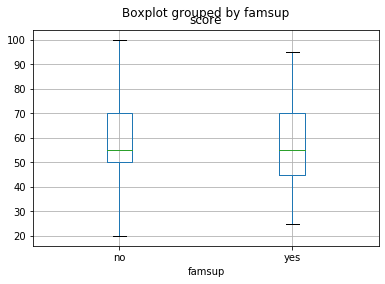

In [184]:
# Удалим строки с пустыми значениями и проверим распределение на графике

df = stud[~stud.famsup.isnull()]
df.boxplot(column='score', by='famsup')

In [185]:
# Визуально данные мало отличаются
# Проверим значимость на выборках

print(get_stat_dif(df, 'famsup', 'score', True))
print(get_stat_dif(df, 'famsup', 'score', False))

Для порога 0.05 по критерию Стьюдента значимости нет: min(p_value) = 0.4063096650270416
Для порога 0.05 по критерию Манна-Уитни значимости нет: min(p_value) = 0.2193648714020902


In [186]:
# Наличие поддержки в учебе в семье незначимо. Все тесты дают p_value > 0.05.
# Удалим столбец

drop('famsup')

### Вывод для famsup: не влияет на оценки 

### Столбец paid

In [187]:
# paid
# Проверим уникальные и пустые значения

print('Уникальных значений paid: ' + str(stud.paid.nunique()))
print('Незаполненных значений paid: ' + str(len(stud[stud.paid.isnull()].paid.index)))
pd.DataFrame(stud.paid.value_counts())

Уникальных значений paid: 2
Незаполненных значений paid: 36


,paid
no,170
yes,146


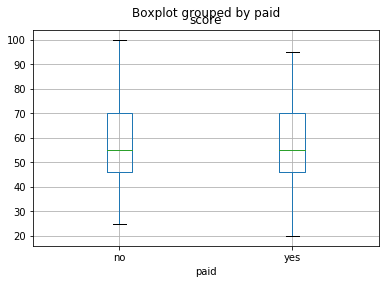

In [188]:
# Удалим строки с пустыми значениями и проверим распределение на графике

df = stud[~stud.paid.isnull()]
df.boxplot(column='score', by='paid')

In [189]:
# Даже не станем проводить корреляционные тесты, поскольку графики почти не отличаются
# и выборки yes и no мало отличаются по количеству.
# Удалим столбец

drop('paid') 

### Вывод для paid: наличие платных занятий на оценки не влияет

### Столбец activities

In [190]:
# activities
# Проверим уникальные и пустые значения

print('Уникальных значений activities: ' + str(stud.activities.nunique()))
print('Незаполненных значений activities: ' + str(len(stud[stud.activities.isnull()].activities.index)))
pd.DataFrame(stud.activities.value_counts())

Уникальных значений activities: 2
Незаполненных значений activities: 12


,activities
yes,172
no,168


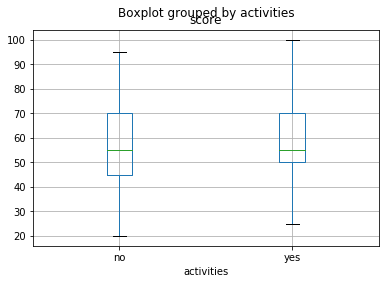

In [191]:
# Удалим строки с пустыми значениями и проверим распределение на графике

df = stud[~stud.activities.isnull()]
df.boxplot(column='score', by='activities')

In [192]:
# Снова не станем проводить корреляционные тесты, поскольку графики почти не отличаются
# и выборки yes и no мало отличаются по количеству.
# Удалим столбец

drop('activities') 

### Вывод для activities: наличие внеурочных занятий на оценки не влияет

### Столбец nursery

In [193]:
# nursery
# Проверим уникальные и пустые значения

print('Уникальных значений nursery: ' + str(stud.nursery.nunique()))
print('Незаполненных значений nursery: ' + str(len(stud[stud.nursery.isnull()].nursery.index)))
pd.DataFrame(stud.nursery.value_counts())

Уникальных значений nursery: 2
Незаполненных значений nursery: 12


,nursery
yes,272
no,68


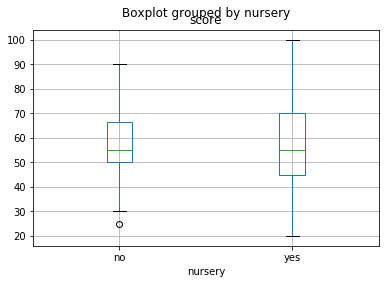

In [194]:
# Удалим строки с пустыми значениями и проверим распределение на графике

df = stud[~stud.nursery.isnull()]
df.boxplot(column='score', by='nursery')

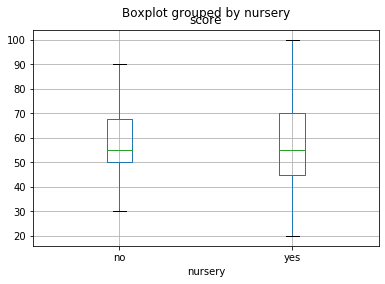

In [195]:
# Уберем выбросы для значения no

df = df[~((df.nursery=='no') & (df.score<30))]
df.boxplot(column='score', by='nursery')

In [196]:
# Разброс выше у ходивших в детский сад. 
# Домашние дети более стабильны по оценкам - возможно, из-за опеки (поддержка/подавление) матери. 
# Скорее всего, у ходивших в садик был своего рода естественный отбор: 
# сильные дети либо продвинулись, а слабые ослабли.
# В остальном зависимости почти нет.

# Проверим значимость на выборках

print(get_stat_dif(df, 'nursery', 'score', True))
print(get_stat_dif(df, 'nursery', 'score', False))

Для порога 0.05 по критерию Стьюдента значимости нет: min(p_value) = 0.7375634911982036
Для порога 0.05 по критерию Манна-Уитни значимости нет: min(p_value) = 0.47045760701862804


In [197]:
# p_value > 0.05
# Удалим столбец

drop('nursery') 

### Вывод для nursery: посещение детского сада для оценки не значимо

### Столбец higher

In [198]:
# higher
# Проверим уникальные и пустые значения

print('Уникальных значений higher: ' + str(stud.higher.nunique()))
print('Незаполненных значений higher: ' + str(len(stud[stud.higher.isnull()].higher.index)))
pd.DataFrame(stud.higher.value_counts())

Уникальных значений higher: 2
Незаполненных значений higher: 19


,higher
yes,320
no,13


In [199]:
# Значений "no" очень мало. Удалим строки с пустыми значениями, обратим в числа и проверим выбросы

dct = {'yes': 1, 'no': 0}
stud['num_higher'] = stud['higher'].map(dct)

df = stud[~stud.higher.isnull()]

out = get_outlier(df,'num_higher')
print('Количество выбросов:', out.count())
display(out)

Количество выбросов: 13


78     0.0
127    0.0
163    0.0
164    0.0
165    0.0
166    0.0
247    0.0
252    0.0
276    0.0
311    0.0
352    0.0
361    0.0
371    0.0
Name: num_higher, dtype: float64

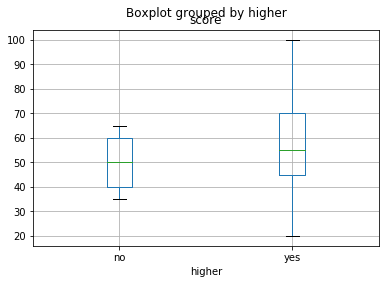

In [200]:
# Все значения  No являются выбросами! Их слишком мало, чтобы выяснять значимость.
# Посмотрим на график:

df.boxplot(column='score', by='higher')

In [202]:
# Если бы выборка No была бы больше, то, скорее всего, мотивация учиться в университете повлияла бы на оценку
# Проведем тест

print(get_stat_dif(df, 'higher', 'score', True))
print(get_stat_dif(df, 'higher', 'score', False))

Для порога 0.05 по критерию Стьюдента значимости нет: min(p_value) = 0.05604155173577689
Для порога 0.05 по критерию Манна-Уитни значимость есть: для ('yes', 'no') p_value = 0.017953577729633147


In [204]:
# Выборка для No слишком мала, и нерепрезентативна (все No - выбросы).
# И хотя тесты показывают значимость, все-таки удалим столбец,
# потому что использование тестов на такой выборке может быть некорректно.

drop('num_higher')
drop('higher')

### Вывод для higher: желание получать высшее образование влияет на оценки, но выборка распределена слишком неравномерно, чтобы строить модель

### Столбец internet

In [205]:
# internet
# Проверим уникальные и пустые значения

print('Уникальных значений internet: ' + str(stud.internet.nunique()))
print('Незаполненных значений internet: ' + str(len(stud[stud.internet.isnull()].internet.index)))
pd.DataFrame(stud.internet.value_counts())

Уникальных значений internet: 2
Незаполненных значений internet: 29


,internet
yes,274
no,49


In [206]:
# Значений "no" мало. Удалим строки с пустыми значениями, обратим в числа и проверим выбросы

dct = {'yes': 1, 'no': 0}
stud['num_internet'] = stud['internet'].map(dct)

df = stud[~stud.internet.isnull()]

out = get_outlier(df,'num_internet')
print('Количество выбросов:', out.count())
display(out.head(5))

Количество выбросов: 49


4     0.0
7     0.0
17    0.0
35    0.0
39    0.0
Name: num_internet, dtype: float64

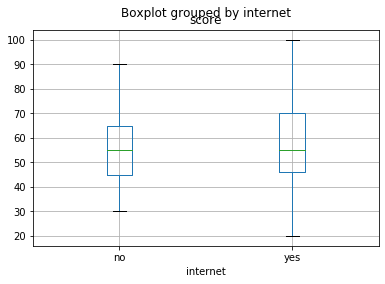

In [207]:
# Все No являются выбросами.
# Посмотрим на график:

df.boxplot(column='score', by='internet')

In [208]:
# Графики мало отличаются (кроме размаха)
# Удалим столбец без тестов

drop('internet')
drop('num_internet')

### Вывод для internet: столбец не значим для оценки

### Столбец romantic

In [209]:
# romantic
# Проверим уникальные и пустые значения

print('Уникальных значений romantic: ' + str(stud.romantic.nunique()))
print('Незаполненных значений romantic: ' + str(len(stud[stud.romantic.isnull()].romantic.index)))
pd.DataFrame(stud.romantic.value_counts())

Уникальных значений romantic: 2
Незаполненных значений romantic: 29


,romantic
no,219
yes,104


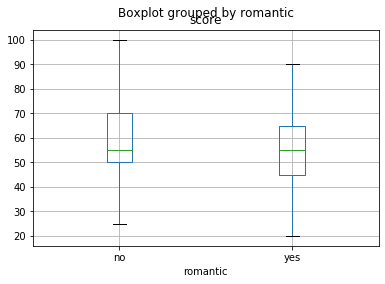

In [210]:
# Удалим строки с пустыми значениями и проверим распределение на графике

df = stud[~stud.romantic.isnull()]
df.boxplot(column='score', by='romantic')

In [211]:
# Медианы примерно одинаковые, но в целом влюбленные ученики хуже учатся
# Проведем тест

print(get_stat_dif(df, 'romantic', 'score', True))
print(get_stat_dif(df, 'romantic', 'score', False))

Для порога 0.05 по критерию Стьюдента значимости нет: min(p_value) = 0.2668414509361285
Для порога 0.05 по критерию Манна-Уитни значимости нет: min(p_value) = 0.22195782784137014


In [215]:
# Тесты демонстрируют независимость выборок
# Удалим столбец

drop('romantic')

# Построение модели

In [216]:
# Удалим из датасета столбцы, не влияющие на оценки

for col in drop_list:
    if col in stud.columns:
        stud = stud.drop(col, axis=1)

In [217]:
# Модель готова

stud.head(10)

,sex,age,address,Medu,Mjob,schoolsup,goout,absences,score,gr_studytime,gr_failures,gr_health
0,F,18,U,4.0,at_home,yes,4.0,6.0,30.0,0,0,1
1,F,17,U,1.0,at_home,no,3.0,4.0,30.0,0,0,1
2,F,15,U,1.0,at_home,yes,2.0,10.0,50.0,0,1,1
3,F,15,U,4.0,health,no,2.0,2.0,75.0,1,0,1
4,F,16,U,3.0,other,no,2.0,4.0,50.0,0,0,1
5,M,16,U,4.0,services,no,2.0,10.0,75.0,0,0,1
6,M,16,None,2.0,other,no,4.0,0.0,55.0,0,0,1
7,F,17,U,4.0,other,yes,4.0,6.0,30.0,0,0,0
8,M,15,U,3.0,services,no,2.0,0.0,95.0,0,0,0
9,M,15,U,3.0,other,no,1.0,0.0,75.0,0,0,1


In [ ]:
'''
Выводы:

1) Распределение исследуемой величины - оценки score - условно нормальное. 
Поэтому исследовать зависимости параметров желательно разными корреляционными тестами:
для нормального распределения величины и для распределения, не являющегося нормальным.
В случае разных результатов тестов о значимости параметра, 
решение должно приниматься на основе здравого смысла.

2) Пустые значения оценки и оценки = 0 (выбросы) следует исключить из рассмотрения.
Скорее всего, нулевые оценки - это потерянные данные, которые при их наличии
превратили бы распределение оценок в истинно нормальное.

3) Все столбцы, которые удалены из набора данных, не оказывают значимого влияния на оценки.

4) Условия исследования по столбцам модели:

- sex: особых условий нет. Зависимость очень слабая, при необходимости упрощения модели
    столбец можно удалить.

- age: рассматривать возраст <= 18 лет.

- address: заменить NaN на None и рассматривать только непустые значения.

- Medu: рассматривать только непустые значения > 0 и
    удалить строки, у которых Medu=2 и score>=90 одновременно.
    
- Fedu: столбец рекомендуется удалить, ввиду сильной корреляции с Medu,
    но при необходимости более тонкой модели можно его оставить.
    В таком случае предварительно следует удалить строки с пустыми значениями и значениями = 0 или 40.
    
- Mjob: заменить NaN на None и рассматривать только непустые значения,
    а при необходимости упрощения модели столбец удалить ввиду сильной корреляции с Medu
    
- Fjob: столбец рекомендуется удалить, ввиду зависимости лишь от признака <Учитель>/<Не учитель>.
    Необходимо сделать новый столбец, 
    разбив данные на группы <Учитель>/<Не учитель> и исследуя зависимость от этих групп.
    Предварительно следует заменить NaN на None и рассматривать только непустые значения,
    у которых для профессии ='other' оценки score лежат в диапазоне [30;90)
    
- schoolsup: столбец рекомендуется удалить, ввиду обратной заисимости - поддержка зависит от оценок, а не наоборот,
    но при необходимости исследования обратной зависимости и при отсутствии уверенности,
    что значения yes и no не перепутаны, можно столбец оставить.
    В таком случае предварительно следует заменить NaN на None и рассматривать только непустые значения,
    причем для 'yes' оценка (score) должна быть <= 80
    
- goout: рассматривать только непустые значения.

- abcense: рассматривать только непустые значения. Ввиду перекоса данных по четным и нечетным значениям,
    следует нормализовать данные, повысив на 1 балл нечетные оценки, чтобы сделать все четными.
    Затем следует убрать строки с выбросами для значений 20, 22, 24, 26, 28, 30, 38, 40, 54, 56, 76, 212, 386
    
- studytime: рассматривать только непустые значения. Ввиду зависимости от более грубых условий, 
    следует на основе этого столбца создать новый, разбив данные на группы: 
    <Менее 3 часов на уроки>/<3 и более часов на уроки> и исследуя зависимость от этих групп.
    
- failures: рассматривать только непустые значения. Ввиду зависимости от более грубых условий, 
    следует на основе этого столбца создать новый, разбив данные на группы: 
    <Есть неудачи>/<Нет неудач> и исследуя зависимость от этих групп.
    При этом у группы <Есть неудачи> следует исключить выбросы, удалив оценки >= 80
    
- health: рассматривать только непустые значения. Ввиду зависимости от более грубых условий, 
    следует на основе этого столбца создать новый, разбив данные на группы: 
    <Уровень здоровья менее 3 баллов>/<Уровень здоровья 3 и выше> и исследуя зависимость от этих групп.


'''

In [216]:
# А теперь подготовим единый скрипт, который загружает данные из файла и готовит модель

'''----------------------------------------------------------------------------------------------------'''
'''Подготовительный блок'''

import pandas as pd

# список столбцов для удаления
drop_list = []

# функция преобразования пустых или пробельных или NaN данных строкового типа в значение None
def set_None(value):
    if value is None:
        return value
    else:
        str_value = str(value).strip()
        if str_value == '' or str_value.lower() == 'nan':
            return None
        else:
            return str_value
     

'''----------------------------------------------------------------------------------------------------'''
'''Чтение и преобразование пустых значений'''

# Чтение
stud = pd.read_csv('stud_math.csv')

# Удаление строк с отсутствующими и нулевыми оценками.
stud = stud[stud.score > 0]

# Замена строк NaN на None
str_cols = stud.iloc[:, (np.where(stud.dtypes == 'object'))[0]].columns
for col in str_cols:
    stud[col] = stud[col].apply(set_None)
    
    
'''----------------------------------------------------------------------------------------------------'''
'''Группировка данных в новые столбцы и корректировка данных'''

stud['gr_studytime'] = stud.studytime.apply(lambda x: None if x is None else 0 if x<3 else 1)
stud['gr_failures'] = stud.failures.apply(lambda x: None if x is None else 0 if x==0 else 1)
stud['gr_health'] = stud.health.apply(lambda x: None if x is None else 0 if x<3 else 1)
stud['gr_Fjob'] = stud.Fjob.apply(lambda x: None if x is None else 1 if x=='teacher' else 0)
stud['absences'] = stud.absences.apply(lambda x: x+1 if x%2==1 else x)


'''----------------------------------------------------------------------------------------------------'''
'''Удаление незначимых столбцов и столбцов, замененных на группы'''

drop_list.append('studytime, granular')
drop_list.append('Fedu')
drop_list.append('traveltime')
drop_list.append('studytime')
drop_list.append('failures')
drop_list.append('famrel')
drop_list.append('freetime')
drop_list.append('health')
drop_list.append('school')
drop_list.append('famsize')
drop_list.append('Pstatus')
drop_list.append('Fjob')
drop_list.append('guardian')
drop_list.append('reason')
drop_list.append('paid')
drop_list.append('famsup')
drop_list.append('activities') 
drop_list.append('nursery') 
drop_list.append('higher') 
drop_list.append('internet')
drop_list.append('romantic')

for col in drop_list:
    if col in stud.columns:
        stud = stud.drop(col, axis=1)
        
stud.head(10)

,sex,age,address,Medu,Mjob,schoolsup,goout,absences,score,gr_studytime,gr_failures,gr_health
0,F,18,U,4.0,at_home,yes,4.0,6.0,30.0,0,0,1
1,F,17,U,1.0,at_home,no,3.0,4.0,30.0,0,0,1
2,F,15,U,1.0,at_home,yes,2.0,10.0,50.0,0,1,1
3,F,15,U,4.0,health,no,2.0,2.0,75.0,1,0,1
4,F,16,U,3.0,other,no,2.0,4.0,50.0,0,0,1
5,M,16,U,4.0,services,no,2.0,10.0,75.0,0,0,1
6,M,16,None,2.0,other,no,4.0,0.0,55.0,0,0,1
7,F,17,U,4.0,other,yes,4.0,6.0,30.0,0,0,0
8,M,15,U,3.0,services,no,2.0,0.0,95.0,0,0,0
9,M,15,U,3.0,other,no,1.0,0.0,75.0,0,0,1
